# Unzip the dataset

In [ ]:
import os
import zipfile

In [ ]:
zip_file_path_dataset = '/workspace/datasets/isic2024-resized128.zip'
extract_to_dir_dataset = '/workspace/datasets/isic2024-resized128'
os.makedirs(extract_to_dir_dataset, exist_ok=True)
with zipfile.ZipFile(zip_file_path_dataset, 'r') as zip_ref:
    zip_ref.extractall(extract_to_dir_dataset)
print(f'Files extracted to {extract_to_dir_dataset}')

In [ ]:
zip_file_path_dataset = '/workspace/datasets/isic2019-resized128.zip'
extract_to_dir_dataset = '/workspace/datasets/isic2019-resized128'
os.makedirs(extract_to_dir_dataset, exist_ok=True)
with zipfile.ZipFile(zip_file_path_dataset, 'r') as zip_ref:
    zip_ref.extractall(extract_to_dir_dataset)
print(f'Files extracted to {extract_to_dir_dataset}')

In [ ]:
zip_file_path_dataset = '/workspace/datasets/isic2020-resized128.zip'
extract_to_dir_dataset = '/workspace/datasets/isic2020-resized128'
os.makedirs(extract_to_dir_dataset, exist_ok=True)
with zipfile.ZipFile(zip_file_path_dataset, 'r') as zip_ref:
    zip_ref.extractall(extract_to_dir_dataset)
print(f'Files extracted to {extract_to_dir_dataset}')

# Import necessary libraries & CONFIG & Seeding

In [ ]:
!pip install pandas matplotlib wandb timm -q

In [9]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import torchvision.utils as vutils
import numpy as np
import random
import timm
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import wandb
import torch.nn.functional as F

In [10]:
# Configuration dictionary
CONFIG = {
    'model_name': 'efficientnet_b0',
    'pretrained': True,
    'num_epochs': 3,
    'learning_rate': 0.0001,
    'batch_size': 32,
    'seed': 42,
    'project_name': 'ISIC_2024_Competition',
    'artifact_name': 'isic2024-base-model',
    'wandb_log': True,
    'dataset_mode': 'combined_practice',  # '2019', 'combined', or 'combined_practice'
    'loss_function': 'focal',  # 'bce' or 'focal'
    'input_size': (128, 128)  # Change input size here
}

In [11]:
# Function to set seed for reproducibility
def seeding(seed):
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = False
        torch.backends.cudnn.benchmark = True
    print("Seeding done ...")

# Dataset Preprocess & plot data distribution

In [12]:
# Function to load and preprocess data
def load_and_preprocess_data(config):
    if config['dataset_mode'] == '2019':
        # Load 2019 metadata
        isic2019_path = './datasets/isic2019-resized128/train-metadata.csv'
        df_2019 = pd.read_csv(isic2019_path, usecols=['isic_id', 'target'])

        # Filter malignant data (target == 1)
        df_2019_malignant = df_2019[df_2019['target'] == 1].copy()

        # Add columns for image path and year using .loc to avoid SettingWithCopyWarning
        df_2019_malignant.loc[:, 'image_path'] = './datasets/isic2019-resized128/train-image/image/' + df_2019_malignant['isic_id'] + '.jpg'
        df_2019_malignant.loc[:, 'year'] = 2019

        return df_2019_malignant, df_2019

    elif config['dataset_mode'] == 'combined':
        # Load 2024 metadata
        isic2024_path = './datasets/isic2024-resized128/train-metadata.csv'
        df_2024 = pd.read_csv(isic2024_path, usecols=['isic_id', 'target'])

        # Add columns for image path and year
        df_2024['image_path'] = './datasets/isic2024-resized128/train-image/image/' + df_2024['isic_id'] + '.jpg'
        df_2024['year'] = 2024

        # Load 2019 and 2020 metadata
        isic2019_path = './datasets/isic2019-resized128/train-metadata.csv'
        isic2020_path = './datasets/isic2020-resized128/train-metadata.csv'
        df_2019 = pd.read_csv(isic2019_path, usecols=['isic_id', 'target'])
        df_2020 = pd.read_csv(isic2020_path, usecols=['isic_id', 'target'])

        # Filter malignant data (target == 1)
        df_2019_malignant = df_2019[df_2019['target'] == 1].copy()
        df_2020_malignant = df_2020[df_2020['target'] == 1].copy()

        # Add columns for image path and year
        df_2019_malignant['image_path'] = './datasets/isic2019-resized128/train-image/image/' + df_2019_malignant['isic_id'] + '.jpg'
        df_2020_malignant['image_path'] = './datasets/isic2020-resized128/train-image/image/' + df_2020_malignant['isic_id'] + '.jpg'
        df_2019_malignant['year'] = 2019
        df_2020_malignant['year'] = 2020

        # Combine with 2024 dataset
        df_combined = pd.concat([df_2024, df_2019_malignant, df_2020_malignant], ignore_index=True)

        return df_combined, df_2024

    elif config['dataset_mode'] == 'combined_practice':
        # Load 2024 metadata
        isic2024_path = './datasets/isic2024-resized128/train-metadata.csv'
        df_2024 = pd.read_csv(isic2024_path, usecols=['isic_id', 'target'])

        # Add columns for image path and year
        df_2024['image_path'] = './datasets/isic2024-resized128/train-image/image/' + df_2024['isic_id'] + '.jpg'
        df_2024['year'] = 2024

        # Load 2019 and 2020 metadata
        isic2019_path = './datasets/isic2019-resized128/train-metadata.csv'
        isic2020_path = './datasets/isic2020-resized128/train-metadata.csv'
        df_2019 = pd.read_csv(isic2019_path, usecols=['isic_id', 'target'])
        df_2020 = pd.read_csv(isic2020_path, usecols=['isic_id', 'target'])

        # Filter malignant data (target == 1)
        df_2019_malignant = df_2019[df_2019['target'] == 1].copy()
        df_2020_malignant = df_2020[df_2020['target'] == 1].copy()
        df_2024_malignant = df_2024[df_2024['target'] == 1].copy()

        # Filter 20% of benign data (target == 0) in 2024 dataset
        df_2024_benign = df_2024[df_2024['target'] == 0].copy()
        df_2024_benign_sampled = df_2024_benign.sample(frac=0.2, random_state=config['seed'])

        # Add columns for image path and year
        df_2019_malignant['image_path'] = './datasets/isic2019-resized128/train-image/image/' + df_2019_malignant['isic_id'] + '.jpg'
        df_2020_malignant['image_path'] = './datasets/isic2020-resized128/train-image/image/' + df_2020_malignant['isic_id'] + '.jpg'
        df_2024_malignant['image_path'] = './datasets/isic2024-resized128/train-image/image/' + df_2024_malignant['isic_id'] + '.jpg'
        df_2024_benign_sampled['image_path'] = './datasets/isic2024-resized128/train-image/image/' + df_2024_benign_sampled['isic_id'] + '.jpg'
        df_2019_malignant['year'] = 2019
        df_2020_malignant['year'] = 2020
        df_2024_malignant['year'] = 2024
        df_2024_benign_sampled['year'] = 2024

        # Combine datasets
        df_combined_practice = pd.concat([df_2024_malignant, df_2024_benign_sampled, df_2019_malignant, df_2020_malignant], ignore_index=True)

        return df_combined_practice, df_2024

In [13]:
# Function to visualize data distribution
def plot_data_distribution(df, df_2024=None):
    if df_2024 is None:
        class_counts = df['target'].value_counts()
        class_counts.plot(kind='bar')
        plt.title('Data Distribution in ISIC 2019 Dataset')
        plt.xlabel('Target')
        plt.ylabel('Count')
        plt.xticks([0, 1], ['Class 0', 'Class 1'], rotation=0)
        plt.show()
    else:
        # Plot 2024 dataset distribution before combining
        df_2024['target'].value_counts().plot(kind='bar')
        plt.title('Initial Data Distribution in ISIC 2024')
        plt.xlabel('Target')
        plt.ylabel('Count')
        plt.show()

        # Plot combined dataset distribution
        df['target'].value_counts().plot(kind='bar')
        plt.title('Data Distribution After Combining ISIC 2019 and 2020 Malignant Data with 2024')
        plt.xlabel('Target')
        plt.ylabel('Count')
        plt.show()

# Pytorch Dataset

In [14]:
# PyTorch Dataset class
class ISICDataset(Dataset):
    def __init__(self, metadata, transform=None):
        self.metadata = metadata
        self.transform = transform

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        img_name = self.metadata.iloc[idx, self.metadata.columns.get_loc('image_path')]
        image = Image.open(img_name).convert('RGB')
        label = int(self.metadata.iloc[idx, self.metadata.columns.get_loc('target')])

        if self.transform:
            image = self.transform(image)

        return image, label

# Custom Focal Loss Function

In [ ]:
# Focal Loss implementation
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        BCE_loss = F.binary_cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduction == 'mean':
            return torch.mean(F_loss)
        elif self.reduction == 'sum':
            return torch.sum(F_loss)
        else:
            return F_loss

# Train

In [15]:
# Function to create and train the model
def train_model(dataloader, config):
    # Initialize wandb if logging is enabled
    if config['wandb_log']:
        wandb.init(project=config['project_name'], config=config, reinit=True)
        wandb_config = wandb.config

    # Load the pretrained model
    model = timm.create_model(config['model_name'], pretrained=config['pretrained'])

    # Ensure all layers are trainable
    for param in model.parameters():
        param.requires_grad = True

    # Adjust the input size for the EfficientNet model
    model.default_cfg['input_size'] = (3, config['input_size'][0], config['input_size'][1])

    # Get the number of features in the last layer
    num_features = model.get_classifier().in_features

    # Replace the classifier layer with a new regression head
    model.classifier = nn.Sequential(
        nn.Linear(num_features, 1),
        nn.Sigmoid()  # Sigmoid to output a probability between 0 and 1
    )

    # Move the model to the appropriate device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)  # Send the model to the device

    # Print the device information and handle multi-GPU setup
    if torch.cuda.device_count() > 1:
        devices = ', '.join([torch.cuda.get_device_name(i) for i in range(torch.cuda.device_count())])
        print(f"Using {torch.cuda.device_count()} GPUs: {devices}")
        model = nn.DataParallel(model)  # Wrap the model for multi-GPU
    else:
        print(f"Using device: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'}")

    # Choose the loss function
    if config['loss_function'] == 'focal':
        criterion = FocalLoss(alpha=1, gamma=2, reduction='mean')  # Adjust alpha and gamma as needed
    else:
        criterion = nn.BCELoss()

    # Training setup
    optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'])

    # Training loop with progress visualization using tqdm
    for epoch in range(config['num_epochs']):
        model.train()
        running_loss = 0.0
        for inputs, labels in tqdm(dataloader, desc=f'Epoch {epoch + 1}/{config["num_epochs"]}', leave=False):
            inputs, labels = inputs.to(device), labels.float().to(device)  # Send inputs and labels to the device

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs).squeeze()  # Get rid of the single dimensional output
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Calculate average loss for the epoch
        avg_loss = running_loss / len(dataloader)
        print(f'Epoch [{epoch + 1}/{config["num_epochs"]}], Loss: {avg_loss:.4f}')

        # Log the loss to wandb if logging is enabled
        if config['wandb_log']:
            wandb.log({"epoch": epoch + 1, "loss": avg_loss})

        # Save the model after each epoch
        os.makedirs("./logs", exist_ok=True)
        model_save_path = f"./logs/{config['artifact_name']}_epoch{epoch + 1}.pth"
        torch.save(model.module.state_dict() if torch.cuda.device_count() > 1 else model.state_dict(), model_save_path)
        print(f"Model saved to {model_save_path} after epoch {epoch + 1}")


# Run in One

In [ ]:
# Function to visualize a batch of images from the DataLoader
def show_image(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

Seeding done ...


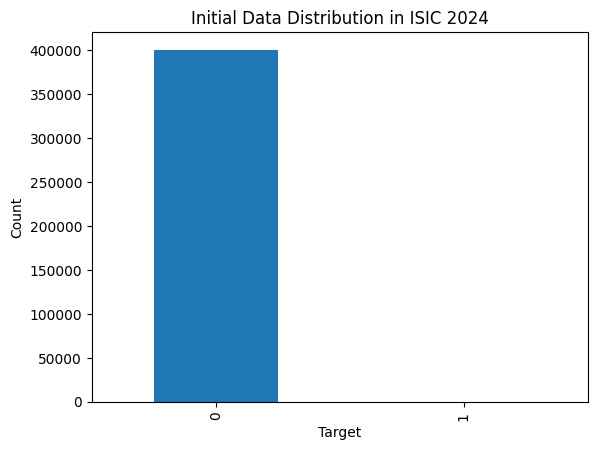

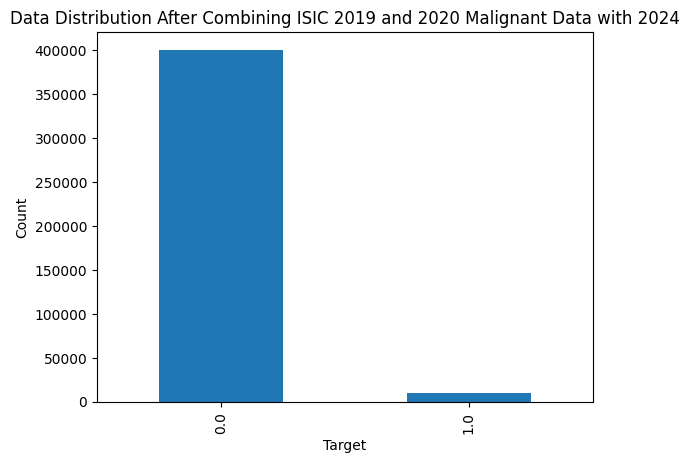

Dataset size: 410116


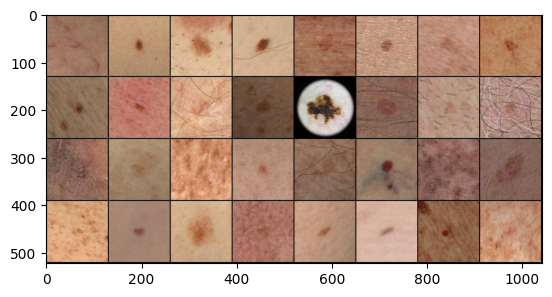

Using 2 GPUs: NVIDIA GeForce RTX 4090, NVIDIA GeForce RTX 4090


Epoch [1/3], Loss: 0.0110
Model saved to ./logs/isic2024-base-model_epoch1.pth after epoch 1


Epoch [2/3], Loss: 0.0062
Model saved to ./logs/isic2024-base-model_epoch2.pth after epoch 2


Epoch 3/3:  10%|▉         | 1257/12817 [10:22<1:32:07,  2.09it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch 3/3:  66%|██████▌   | 8412/12817 [1:09:40<39:08,  1.88it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch 3/3:  96%|█████████▌| 12249/12817 [1:41:20<04:44,  1.99it/s]

In [ ]:

# Set seed for reproducibility
seeding(CONFIG['seed'])

# Load and preprocess data
df_processed, df_2024 = load_and_preprocess_data(CONFIG)

# Visualize data distribution
plot_data_distribution(df_processed, df_2024 if CONFIG['dataset_mode'] in ['combined', 'combined_practice'] else None)

# Define image transformations
transform = transforms.Compose([
    transforms.Resize(CONFIG['input_size']),  # Resize to the specified input size
    transforms.ToTensor()
])

# Create dataset and DataLoader
dataset = ISICDataset(df_processed, transform)
dataloader = DataLoader(dataset, batch_size=CONFIG['batch_size'], shuffle=True)

# Print dataset size
print(f"Dataset size: {len(dataset)}")

# Get a batch of training data and visualize
dataiter = iter(dataloader)
images, labels = next(dataiter)

# Make a grid from batch
out = vutils.make_grid(images)

# Display images
show_image(out)

# Train the model
train_model(dataloader, CONFIG)